In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [2]:
SEED = 1234567890
np.random.seed(SEED)

#### Code 8.1

In [3]:
num_weeks = int(1e5)
positions = np.empty(num_weeks, dtype=np.int64)
current = 9

for i in range(num_weeks):
    # record current position
    positions[i] = current

    # flip coin to generate proposal
    proposal = current + np.random.choice([-1, 1])
    # now make sure he loops around the archipelago
    proposal %= 10
    
    #move?
    prob_move = (proposal + 1) / (current + 1)
    current = proposal if np.random.uniform() < prob_move else current

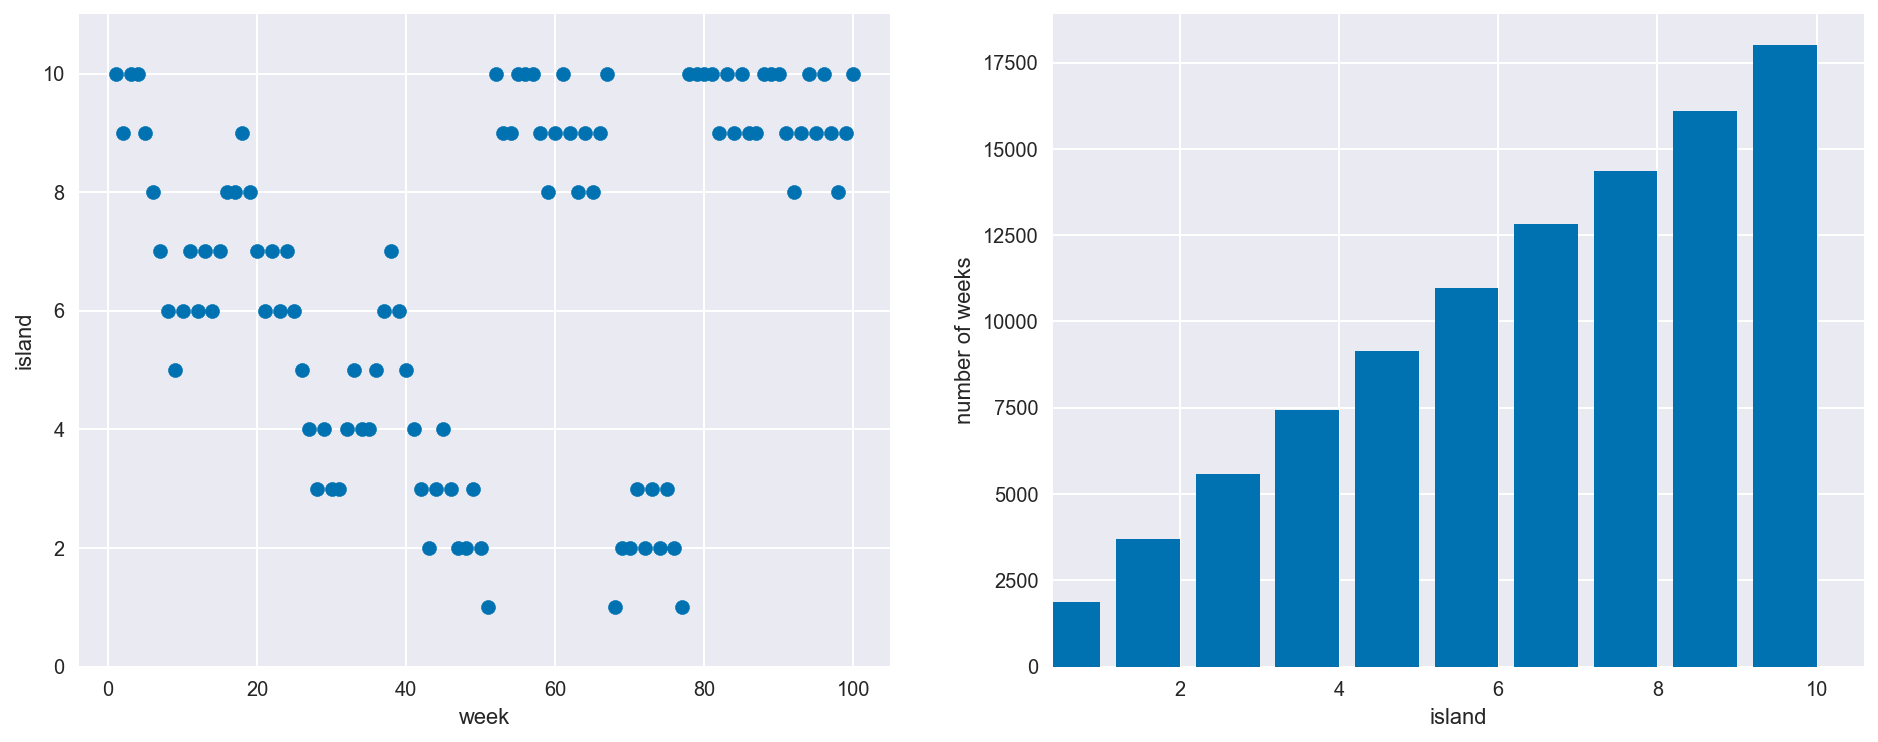

In [4]:
_, (week_ax, island_ax) = plt.subplots(ncols=2, figsize=(16, 6))

week_ax.scatter(np.arange(100) + 1, positions[:100] + 1);

week_ax.set_xlabel('week');
week_ax.set_ylim(0, 11);
week_ax.set_ylabel('island');

island_ax.bar(np.arange(10) + 0.6, np.bincount(positions));

island_ax.set_xlim(0.4, 10.6);
island_ax.set_xlabel('island');
island_ax.set_ylabel('number of weeks');

#### Code 8.2

In [5]:
rugged_df = (pd.read_csv('Data/rugged.csv', sep=';')
               .assign(log_gdp=lambda df: np.log(df.rgdppc_2000))
               .dropna(subset=['log_gdp']))

#### Code 8.3

In [6]:
with pm.Model() as m8_1_map:
    a = pm.Normal('a', 0., 100.)
    bR = pm.Normal('bR', 0., 10.)
    bA = pm.Normal('bA', 0., 10.)
    bAR = pm.Normal('bAR', 0., 10.)
    mu = a \
            + bR * rugged_df.rugged \
            + bA * rugged_df.cont_africa \
            + bAR * rugged_df.rugged * rugged_df.cont_africa
    
    sigma = pm.Uniform('sigma', 0., 10.)
    
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=rugged_df.log_gdp)

In [7]:
with m8_1_map:
    map_8_1 = pm.find_MAP()

logp = -246.89, ||grad|| = 0.297: 100%|██████████| 36/36 [00:00<00:00, 2637.74it/s]


In [8]:
map_8_1

{'a': array(9.222789236008568),
 'bA': array(-1.94694634027834),
 'bAR': array(0.39290434596134205),
 'bR': array(-0.20265345713381855),
 'sigma': array(0.932678798151842),
 'sigma_interval__': array(-2.274371278607129)}

#### Code 8.5

In [9]:
with pm.Model() as m8_1:
    a = pm.Normal('a', 0., 100.)
    bR = pm.Normal('bR', 0., 10.)
    bA = pm.Normal('bA', 0., 10.)
    bAR = pm.Normal('bAR', 0., 10.)
    mu = a \
            + bR * rugged_df.rugged \
            + bA * rugged_df.cont_africa \
            + bAR * rugged_df.rugged * rugged_df.cont_africa
    
    sigma = pm.HalfCauchy('sigma', 2.)
    
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=rugged_df.log_gdp)

In [10]:
with  m8_1:
    trace_8_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:04<00:00, 443.47it/s]


In [11]:
pm.summary(trace_8_1, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.23,0.13,0.00,9.00,9.43,915.0,1.0
bR,-0.20,0.07,0.00,-0.33,-0.09,969.0,1.0
bA,-1.95,0.22,0.01,-2.33,-1.63,996.0,1.0
bAR,0.39,0.13,0.00,0.19,0.59,1068.0,1.0
sigma,0.95,0.05,0.00,0.86,1.03,1698.0,1.0


#### Code 8.7

In [12]:
with m8_1:
    trace_8_1_4_chains = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:04<00:00, 486.74it/s]


In [13]:
pm.summary(trace_8_1_4_chains, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.22,0.14,0.00,9.00,9.44,866.0,1.0
bR,-0.20,0.08,0.00,-0.33,-0.08,920.0,1.0
bA,-1.95,0.23,0.01,-2.35,-1.63,840.0,1.0
bAR,0.39,0.13,0.00,0.20,0.60,894.0,1.0
sigma,0.95,0.05,0.00,0.86,1.02,1840.0,1.0


#### Code 8.8

In [14]:
trace_8_1_df = pm.trace_to_dataframe(trace_8_1)

In [15]:
trace_8_1_df.head()

,a,sigma,bR,bAR,bA
0,9.309700,0.930245,-0.210175,0.406016,-1.966968
1,9.191749,0.977920,-0.190227,0.323135,-1.765870
2,9.058840,0.944086,-0.174918,0.338204,-1.816070
3,9.132765,0.935275,-0.096740,0.260899,-1.706965
4,9.301999,0.888848,-0.238109,0.621372,-2.108791


#### Code 8.9 and 8.10

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


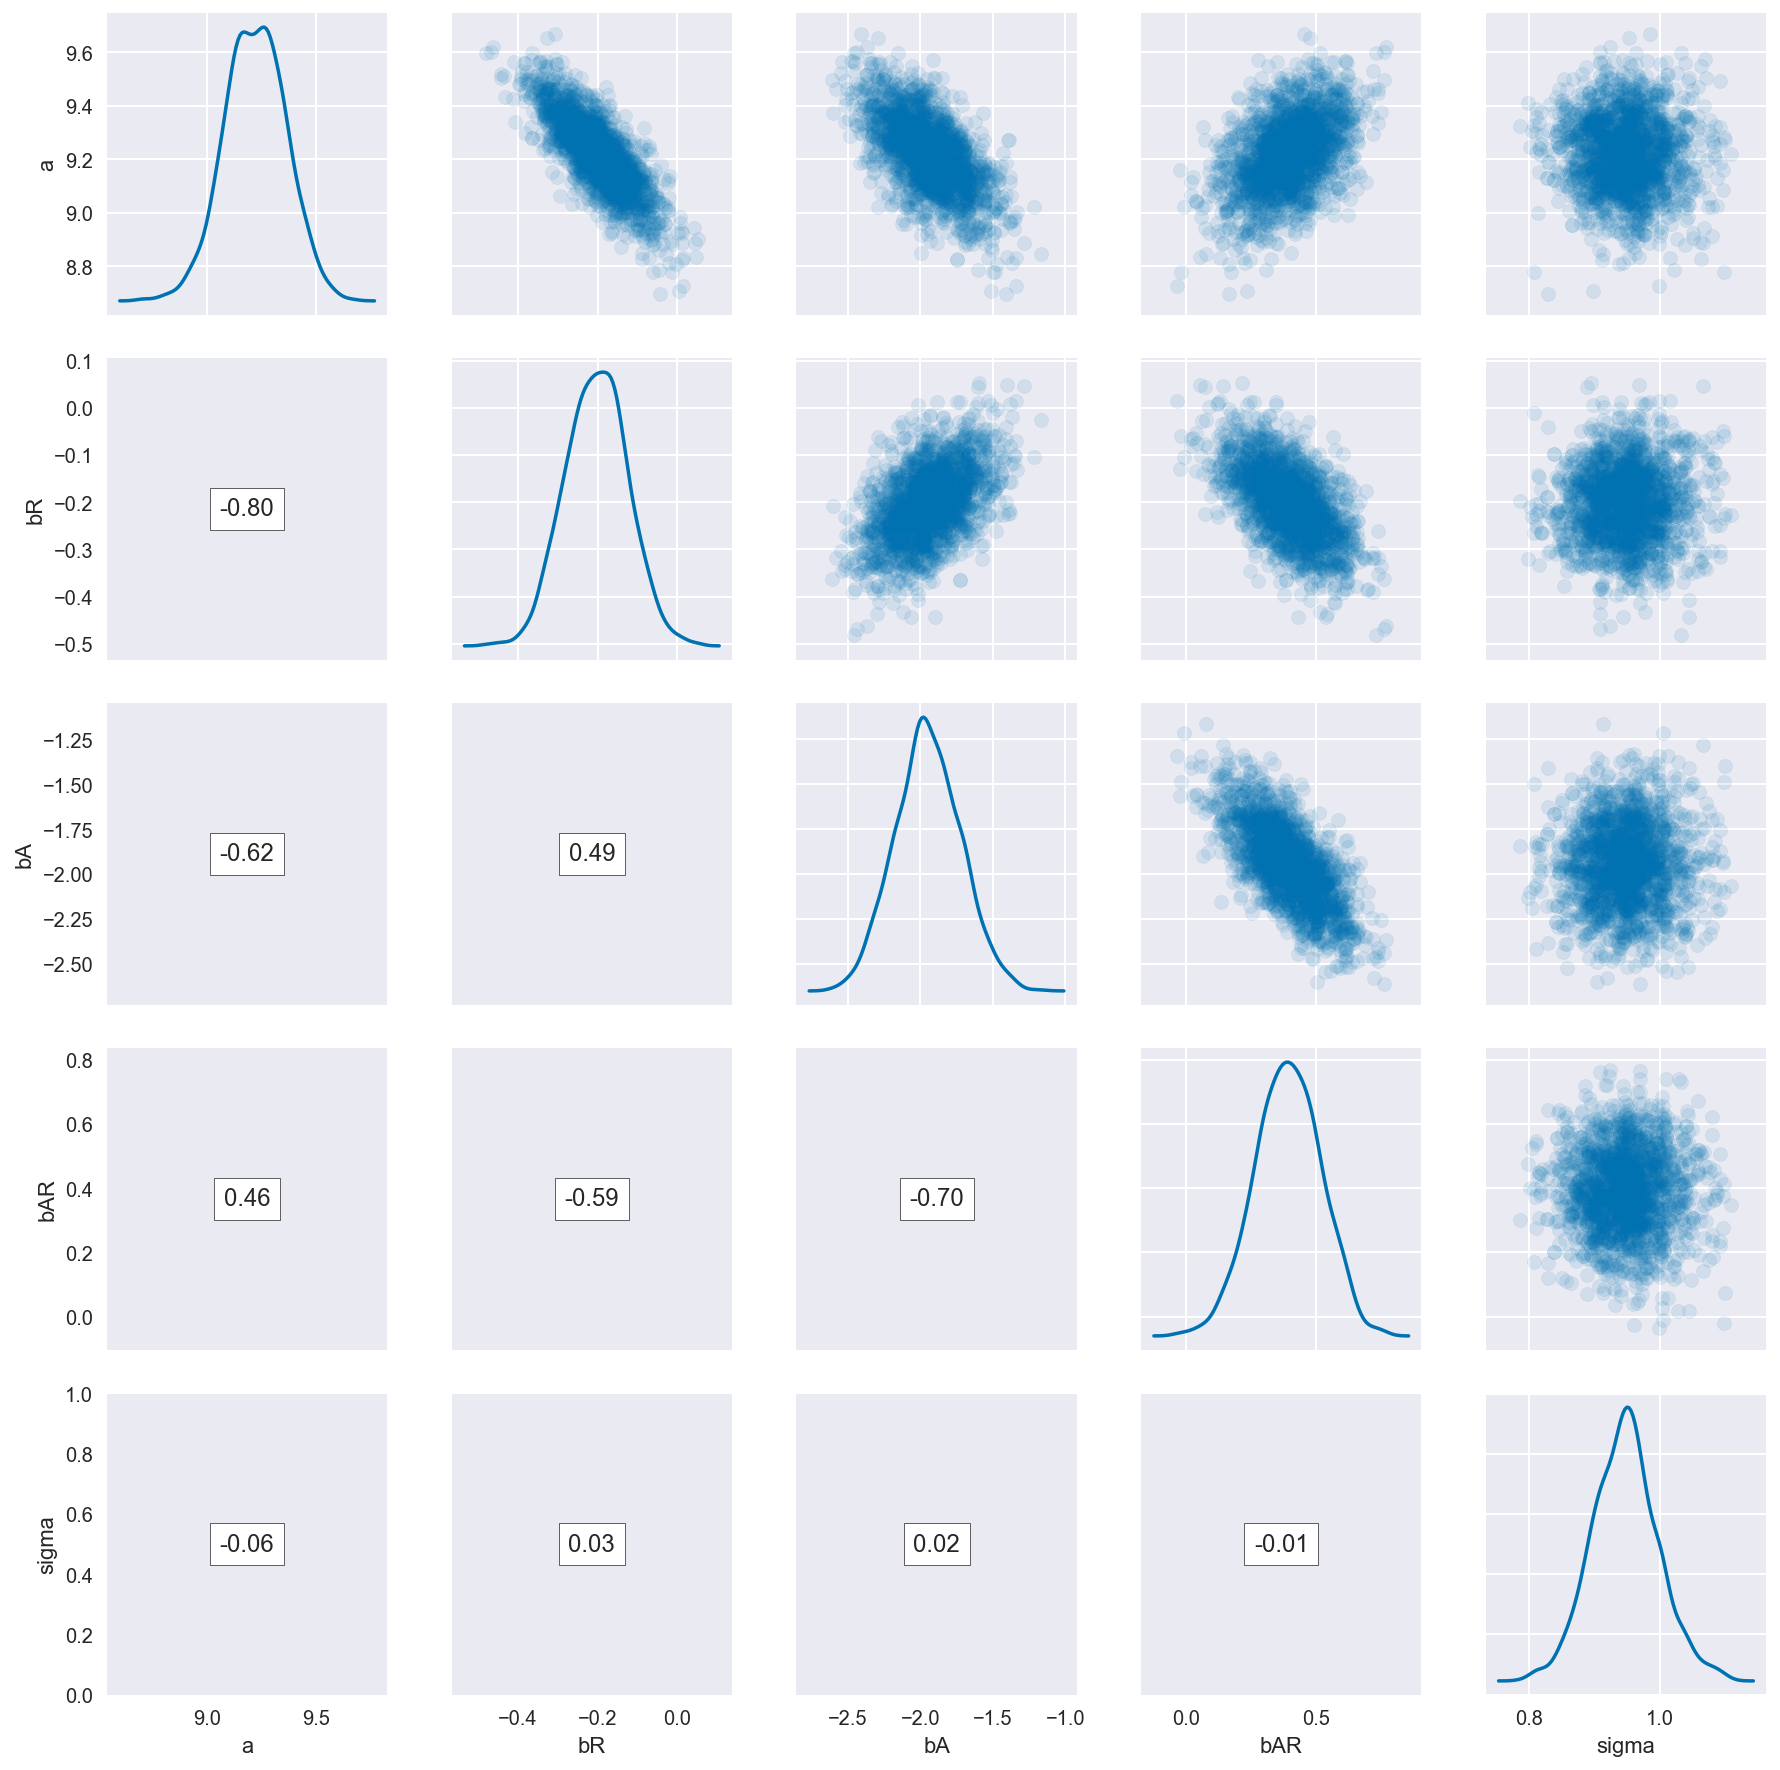

In [16]:
def plot_corr(x, y, **kwargs):
    corrcoeff = np.corrcoef(x, y)[0, 1]
    
    artist = AnchoredText('{:.2f}'.format(corrcoeff), loc=10)
    plt.gca().add_artist(artist)
    plt.grid(b=False)

trace_8_1_df = pm.trace_to_dataframe(trace_8_1_4_chains)
grid = (sns.PairGrid(trace_8_1_df,
                     x_vars=['a', 'bR', 'bA', 'bAR', 'sigma'],
                     y_vars=['a', 'bR', 'bA', 'bAR', 'sigma'],
                     diag_sharey=False)
           .map_diag(sns.kdeplot)
           .map_upper(plt.scatter, alpha=0.1)
           .map_lower(plot_corr))

#### Code 8.11

In [17]:
m8_1.logp({
    varname: trace_8_1[varname].mean()
        for varname in trace_8_1.varnames
})

array(-246.0270687414433)

In [18]:
pm.dic(trace_8_1, model=m8_1)

502.10596010456385

In [19]:
pm.waic(trace_8_1, model=m8_1)

/Users/jlao/Documents/Github/pymc3/pymc3/stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=469.18255290884269, WAIC_se=14.84452996430471, p_WAIC=5.0536791377056218)

#### Code 8.12

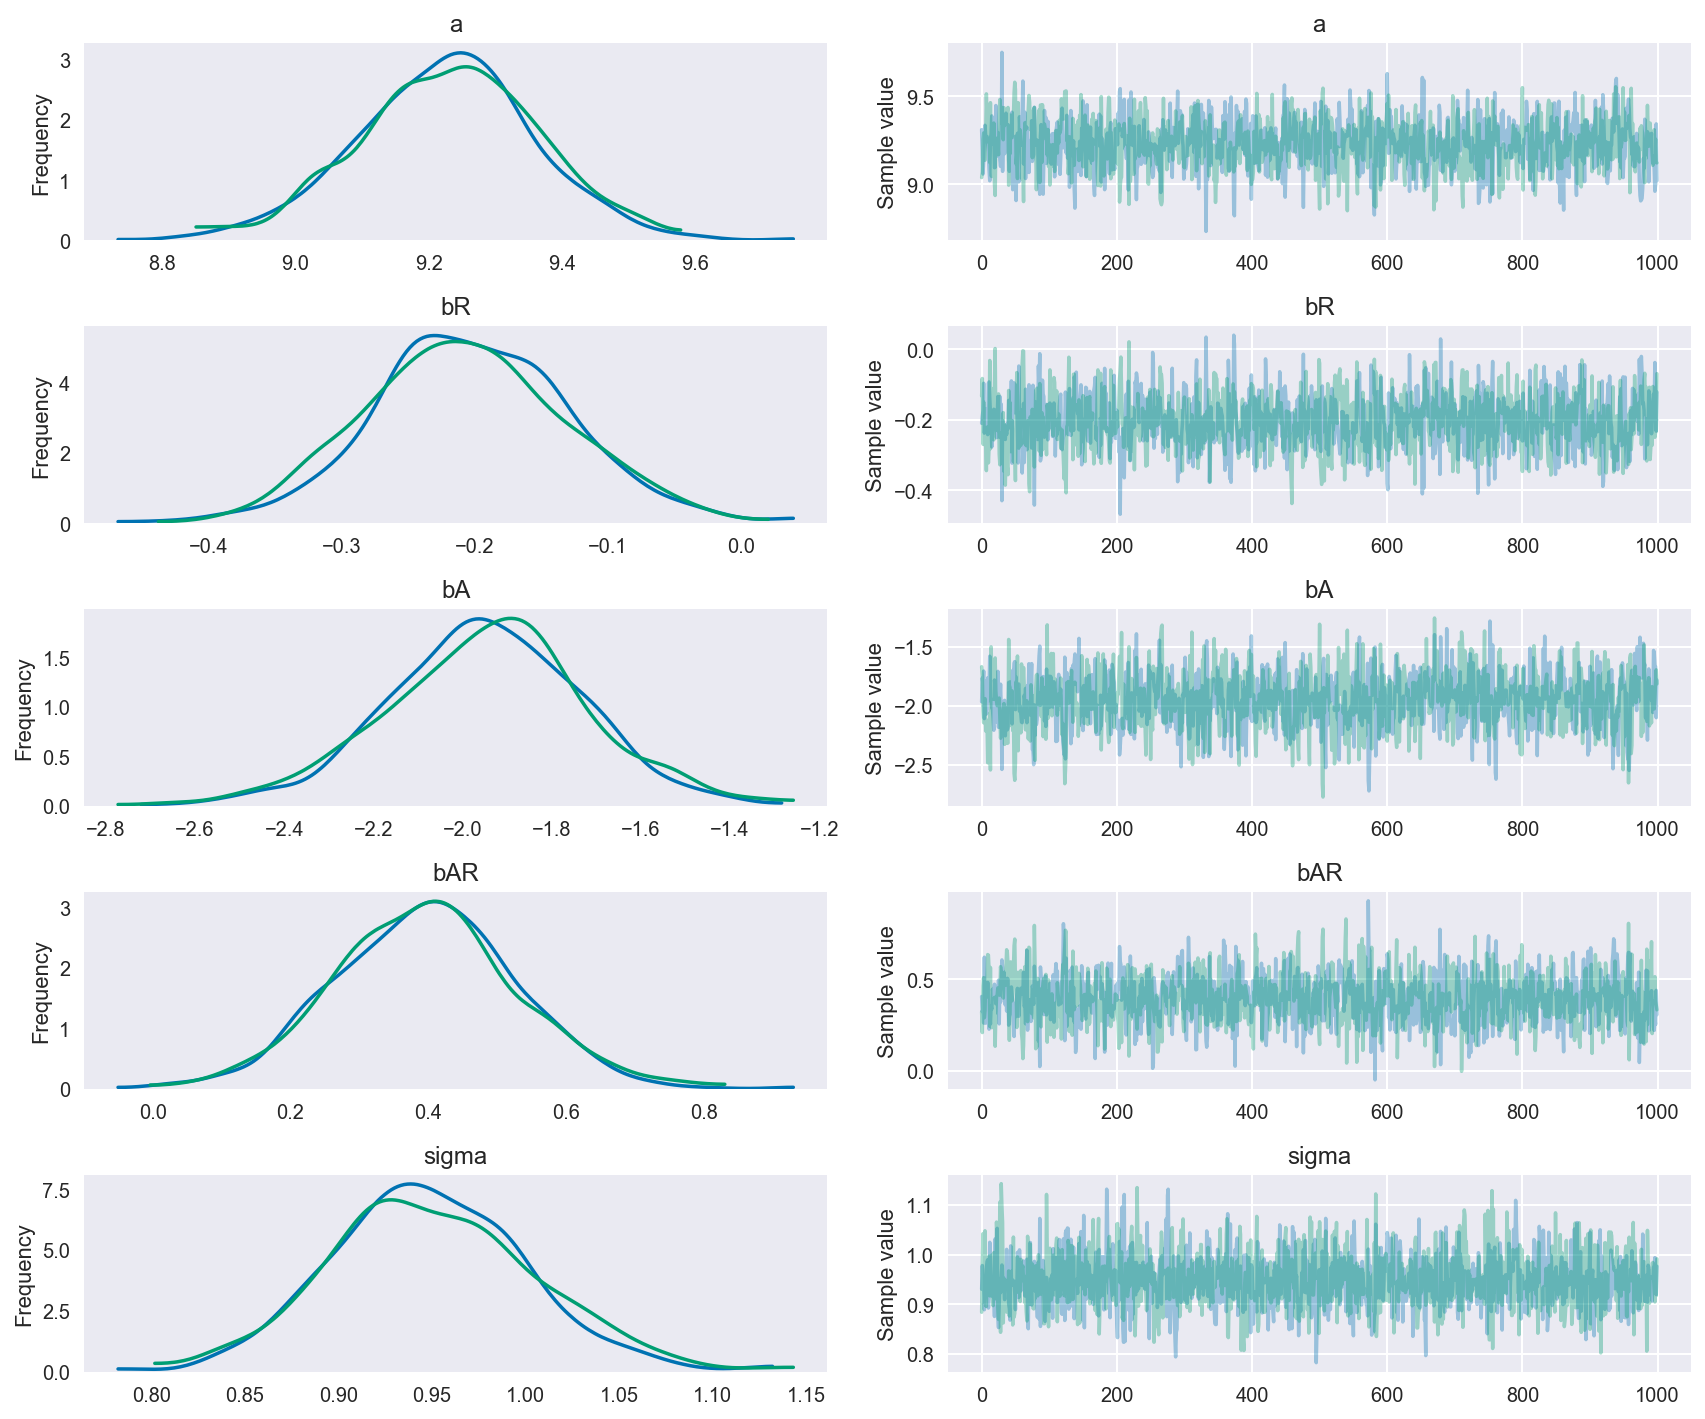

In [20]:
pm.traceplot(trace_8_1);

#### Code 8.13

In [21]:
y = np.array([-1., 1.])

with pm.Model() as m8_2:
    alpha = pm.Flat('alpha')
    sigma = pm.Bound(pm.Flat, lower=0.)('sigma')
    
    y_obs = pm.Normal('y_obs', alpha, sigma, observed=y)

In [22]:
with m8_2:
    trace_8_2 = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 74%|███████▍  | 2957/4000 [00:28<00:40, 26.04it/s] /Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:460: UserWarning: Chain 1 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.903283426786, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 68 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 3998/4000 [00:53<00:00, 364.78it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nut

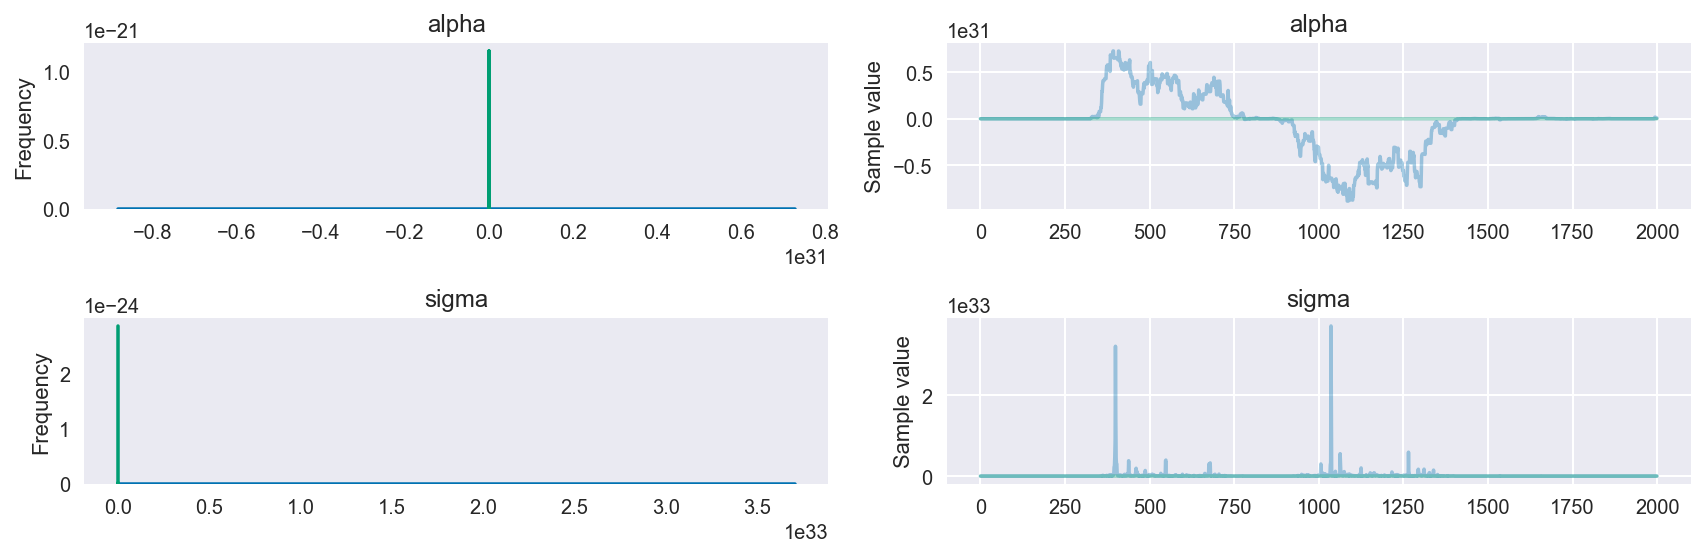

In [23]:
pm.traceplot(trace_8_2);

In [24]:
pm.effective_n(trace_8_2)

{'alpha': 12.0, 'sigma': 844.0}

#### Code 8.14

In [25]:
pm.summary(trace_8_2, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,-1.704713e+29,2.120916e+30,2.080711e+29,-2.622021e+30,4.510133e+30,12.0,1.01
sigma,7.662097e+30,9.172541e+31,2.527326e+30,3.714509e+17,7.810775e+30,844.0,1.01


#### Code 8.15

In [26]:
with pm.Model() as m8_3:
    alpha = pm.Normal('alpha', 1., 10.)
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', alpha, sigma, observed=y)

In [27]:
with m8_3:
    trace_8_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 89%|████████▉ | 1783/2000 [00:01<00:00, 1092.81it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.561464358582, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 11 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2000/2000 [00:02<00:00, 980.17it/s] 


In [28]:
pm.summary(trace_8_3, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,-0.08,1.61,0.07,-2.12,2.37,396.0,1.0
sigma,1.99,1.91,0.08,0.49,3.47,409.0,1.0


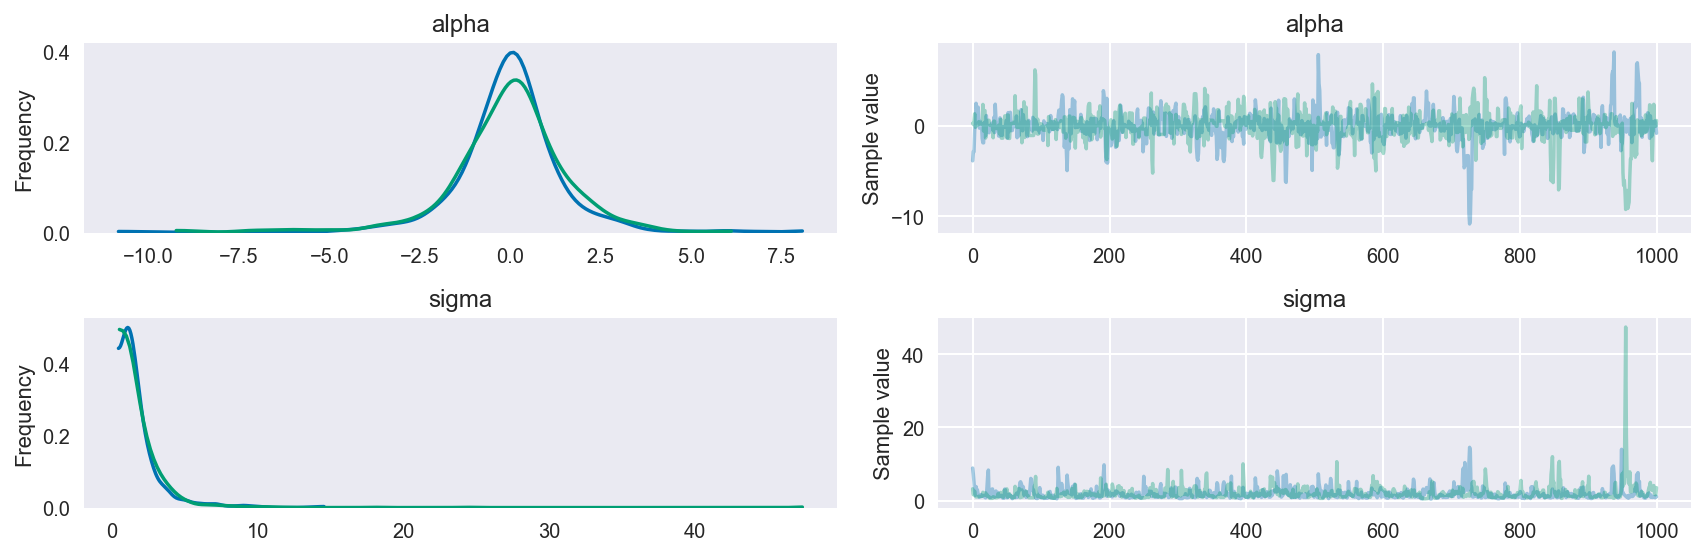

In [29]:
pm.traceplot(trace_8_3);

#### Code 8.16

In [30]:
y = sp.stats.cauchy.rvs(0., 5., size=int(1e4))
mu = y.cumsum() / (1 + np.arange(int(1e4)))

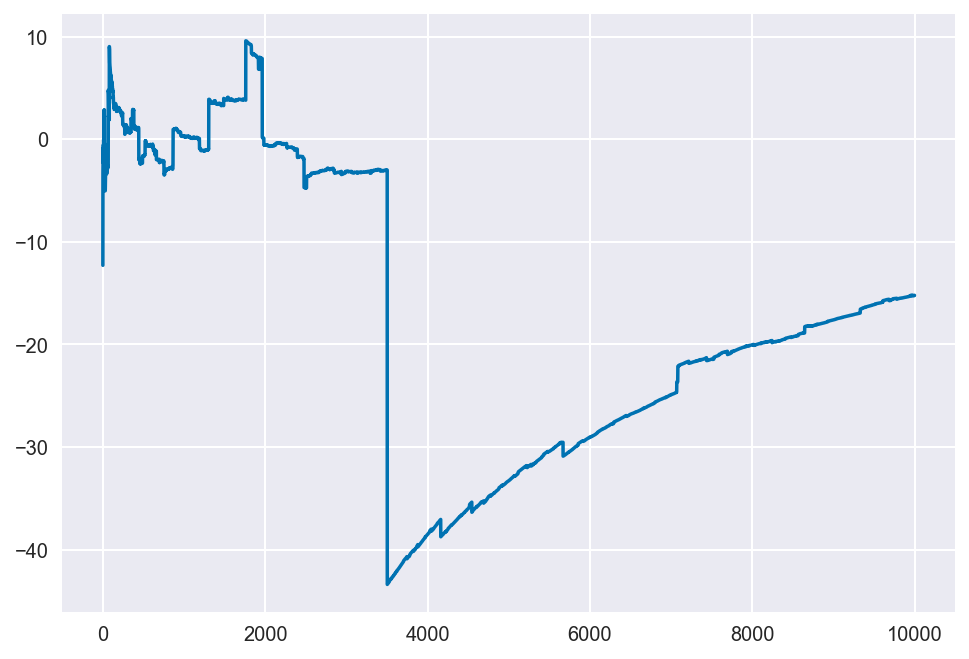

In [31]:
plt.plot(mu);

#### Code 8.17

In [32]:
y = np.random.normal(0., 1., size=100)

#### Code 8.18

In [33]:
with pm.Model() as m8_4:
    a1 = pm.Flat('a1')
    a2 = pm.Flat('a2')
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', a1 + a2, sigma, observed=y)

In [34]:
with m8_4:
    trace_8_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 50%|█████     | 1008/2000 [01:40<02:05,  7.91it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.190739140179, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 89 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2000/2000 [03:37<00:00,  7.52it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:460: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



In [35]:
pm.summary(trace_8_4, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a1,-1575.55,402.16,39.85,-1901.13,-975.77,1.0,2.11
a2,1575.47,402.16,39.85,975.48,1900.90,1.0,2.11
sigma,1.04,0.05,0.00,0.93,1.09,3.0,1.18


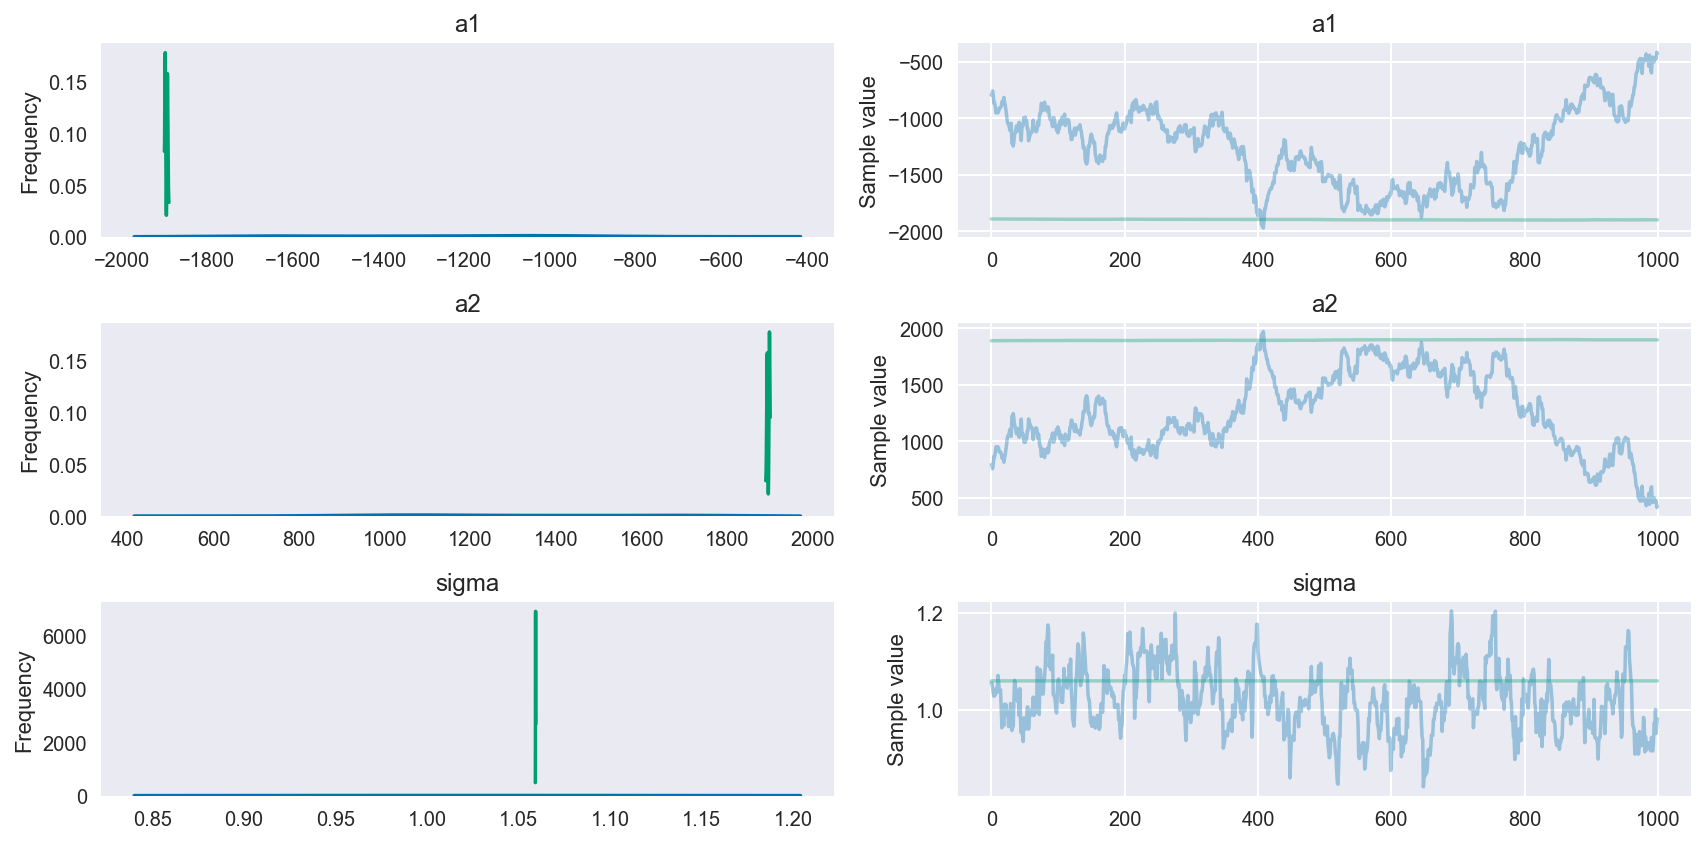

In [36]:
pm.traceplot(trace_8_4);

#### Code 8.19

In [37]:
with pm.Model() as m8_5:
    a1 = pm.Normal('a1', 0., 10.)
    a2 = pm.Normal('a2', 0., 10.)
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', a1 + a2, sigma, observed=y)

In [38]:
with m8_5:
    trace_8_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:58<00:00, 17.95it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.900466304728, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



In [39]:
pm.summary(trace_8_5, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a1,0.39,6.99,0.31,-10.58,11.75,493.0,1.0
a2,-0.47,6.99,0.31,-11.83,10.42,494.0,1.0
sigma,1.01,0.07,0.00,0.89,1.12,739.0,1.0


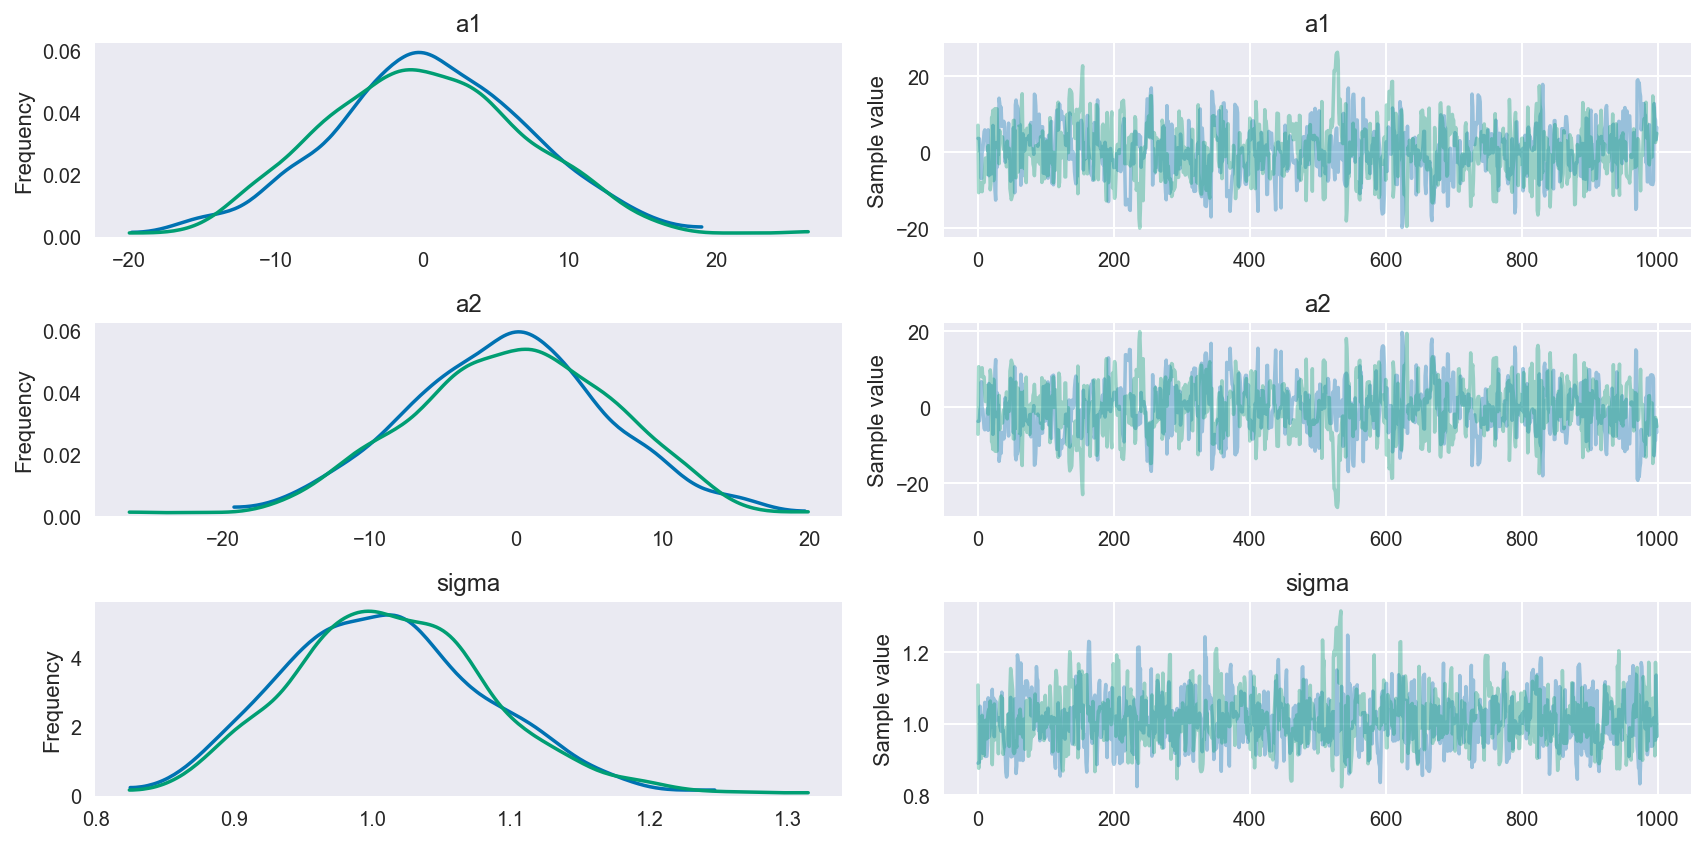

In [40]:
pm.traceplot(trace_8_5);

In [41]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running   and using:
Python 3.5.1
IPython 6.2.1
PyMC3 3.2
NumPy 1.12.0
Pandas 0.20.2
SciPy 0.19.1
Matplotlib 2.0.2

